This notebook is meant to determine how much each DOF perturbs the PSF. This will allow us to determine normalizations when randomly sampling DOF perturbations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth
from donut_sims.dofsToZernikes import dofsToZernikes
from donut_sims.generateDOF import generateDOF

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# identify the name and unit of each DOF

ids = {
    0 : ["M2 dz", "microns"],
    1 : ["M2 dx", "microns"],
    2 : ["M2 dy", "microns"], 
    3 : ["M2 x-rotation", "arcsecs"],
    4 : ["M2 y-rotation", "arcsecs"],
    5 : ["Camera dz", "microns"],
    6 : ["Camera dx", "microns"],
    7 : ["Camera dy", "microns"],
    8 : ["Camera x-rotation", "arcsecs"],
    9 : ["Camera y-rotation", "arcsecs"],
}

for i in range(1, 21):
    ids[i + 9] = [f"M1M3 bending\nmode {i}", "microns"]
    
for i in range(1, 21):
    ids[i + 29] = [f"M2 bending\nmode {i}", "microns"]

In [3]:
# this function calculations the PSF perturbation
# for a DOF perturbation at a given amplitude
# on a given CWFS chip
def calcPSF(i, amp, chip):
    # create the degrees of freedom
    dof = np.zeros(50)
    dof[i] = amp
    
    # calculate the perturbations to the psf
    zk = dofsToZernikes(dof, chip)
    dpsf_per_zk = convertZernikesToPsfWidth(zk)
    dpsf = np.sqrt(np.square(dpsf_per_zk).sum())
    
    return dpsf

In [4]:
# let's calculate PSF perturbations on this grid
# of DOF perturbation amplitudes
amplitudes = [-1, -0.5, 0, 0.5, 1]
psfs = []

for i in range(50):
    meanPSF = []
    
    # loop over the DOF perturbation grid
    for amp in amplitudes:
        
        # calculate the mean PSF across the focal plane
        meanPSF.append(
            np.mean(
                [calcPSF(i, amp, chip) for chip in ("R00", "R40", "R44", "R04")]
            )
        )
        
    psfs.append(meanPSF)
    
psfs = np.array(psfs)

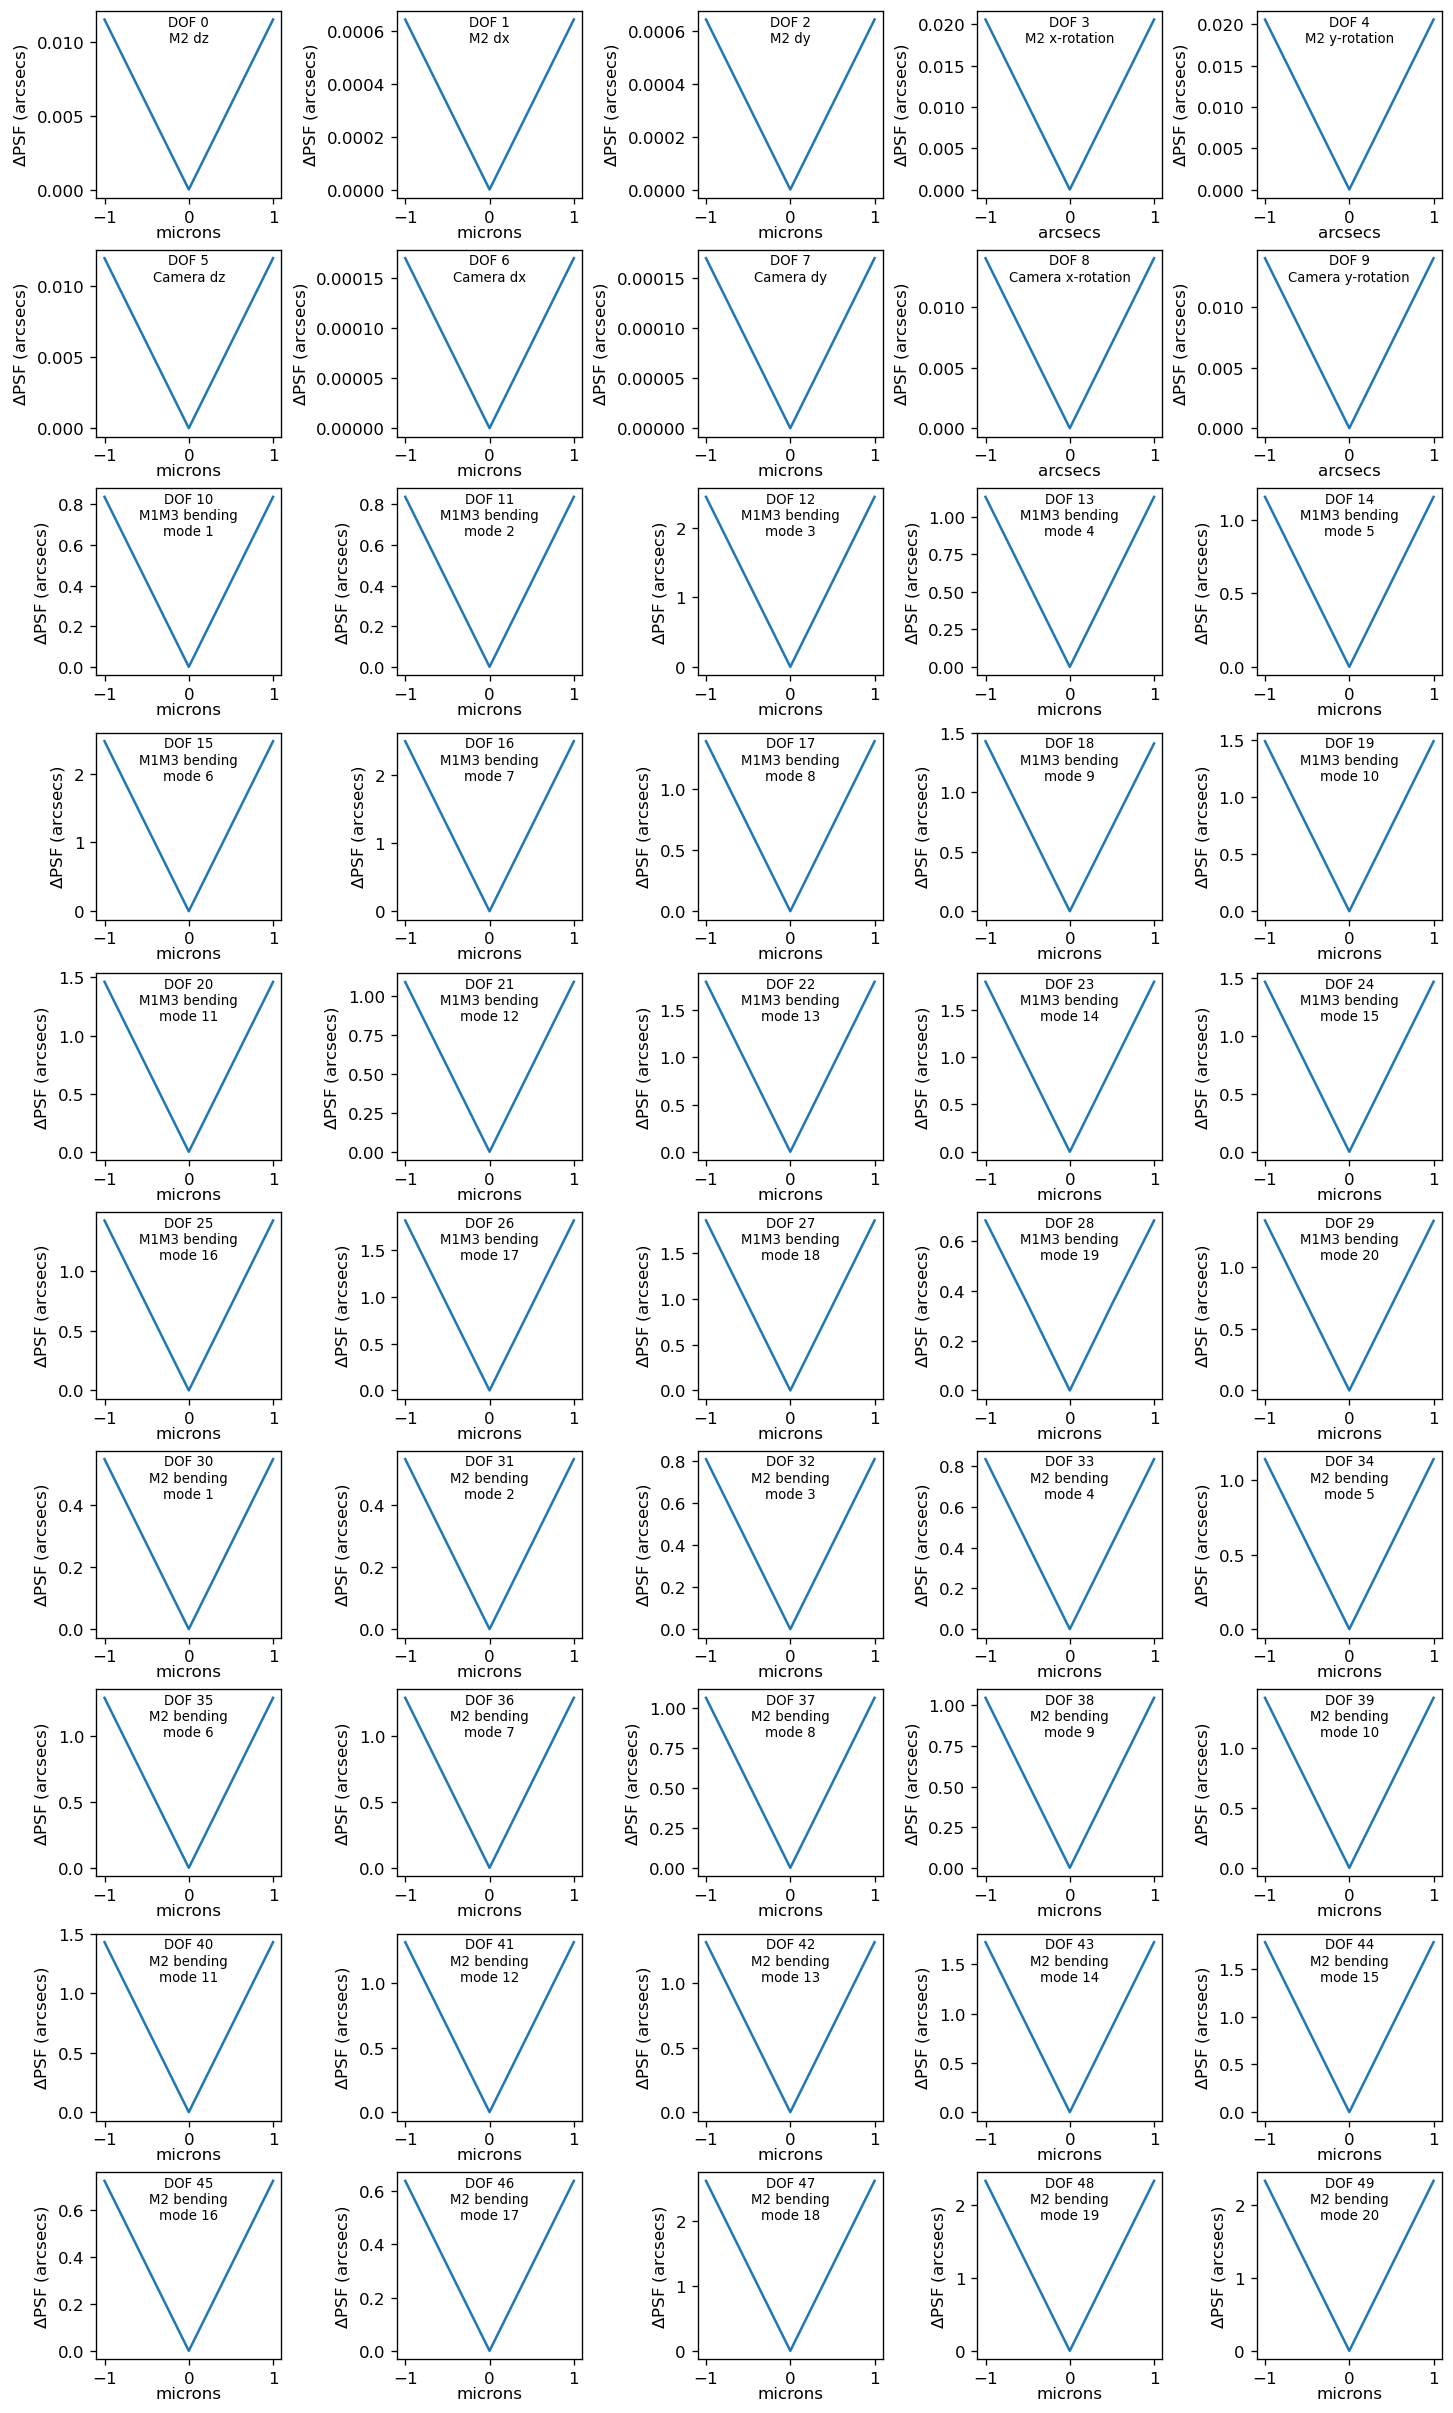

In [5]:
fig, axes = plt.subplots(
    10, 5, 
    figsize=(12, 20), dpi=120, 
    constrained_layout=True,
)

# plot the PSF vs DOF perturbation for all DOFs
for i, ax in enumerate(axes.flatten()):
    
    ax.plot(amplitudes, psfs[i])
    ax.set_xlabel(ids[i][1], labelpad=0)
    ax.set_ylabel("$\Delta$PSF (arcsecs)")
    ax.text(
        0.5, 0.98, f"DOF {i}\n{ids[i][0]}",
        fontsize=8,
        transform=ax.transAxes, ha="center", va="top",
    )

In [6]:
# new norms
norms = psfs[:, -1]

# these are the previously used values
norms0 = np.array(
    [
        2.64e-02,  # 0
        1.08e-03,
        1.08e-03,
        3.28e-02,
        3.28e-02,
        2.64e-02,  # 5
        2.86e-04,
        2.86e-04,
        2.51e-02,
        2.51e-02,
        9.83e-01,  # 10
        9.81e-01,
        6.97e00,
        1.40e00,
        1.35e00,
        6.26e00,  # 15
        6.24e00,
        1.67e00,
        2.55e00,
        3.15e00,
        3.27e00,  # 20
        3.32e00,
        4.07e00,
        2.53e00,
        4.06e00,
        1.40e01,  # 25
        5.00e00,
        7.92e00,
        3.03e00,
        1.90e01,
        6.51e-01,  # 30
        6.51e-01,
        9.58e-01,
        9.88e-01,
        3.31e00,
        3.24e00,  # 35
        3.24e00,
        1.57e00,
        1.28e00,
        2.82e00,
        3.21e00,  # 40
        1.74e00,
        1.76e00,
        3.06e00,
        3.17e00,
        1.78e00,  # 45
        1.75e00,
        1.06e01,
        1.19e01,
        1.20e01,  # 49
    ]
)

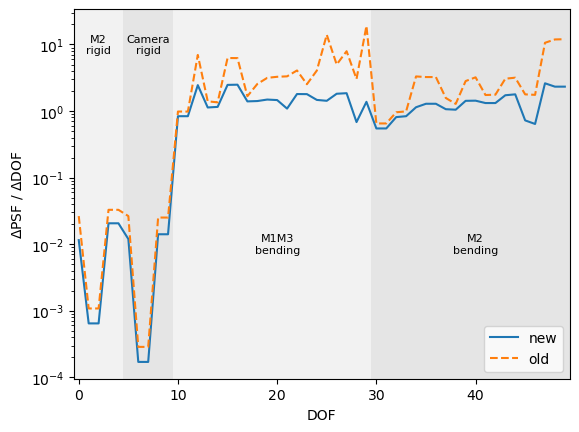

In [7]:
fig, ax = plt.subplots()

ax.plot(norms, label="new")
ax.plot(norms0, ls="--", label="old")
ax.legend(loc="lower right")

ax.axvspan(-0.5,  4.5, color="silver", alpha=0.2, lw=0)
ax.axvspan( 4.5,  9.5, color="silver", alpha=0.4, lw=0)
ax.axvspan( 9.5, 29.5, color="silver", alpha=0.2, lw=0)
ax.axvspan(29.5, 49.5, color="silver", alpha=0.4, lw=0)

ax.text(
    2, 10, "M2\nrigid",
    fontsize=8,
    ha="center", va="center",
)
ax.text(
    7, 10, "Camera\nrigid",
    fontsize=8,
    ha="center", va="center",
)
ax.text(
    20, 1e-2, "M1M3\nbending",
    fontsize=8,
    ha="center", va="center",
)
ax.text(
    40, 1e-2, "M2\nbending",
    fontsize=8,
    ha="center", va="center",
)

ax.set(
    xlabel="DOF",
    xlim=(-0.5, 49.5),
    ylabel="$\Delta$PSF / $\Delta$DOF",
    yscale="log",
)

plt.show()

You can see the shapes are similar, but the old values were overestimated. This means when I sampled perturbations, these perturbations were suppressed below their desired values.

The new values are:

In [10]:
for n in norms:
    print(f"{n:.3e}")

1.149e-02
6.445e-04
6.445e-04
2.057e-02
2.057e-02
1.192e-02
1.700e-04
1.700e-04
1.408e-02
1.408e-02
8.362e-01
8.363e-01
2.450e+00
1.131e+00
1.154e+00
2.471e+00
2.488e+00
1.396e+00
1.412e+00
1.487e+00
1.461e+00
1.088e+00
1.800e+00
1.794e+00
1.469e+00
1.425e+00
1.818e+00
1.854e+00
6.823e-01
1.375e+00
5.474e-01
5.474e-01
8.107e-01
8.361e-01
1.140e+00
1.286e+00
1.286e+00
1.066e+00
1.047e+00
1.423e+00
1.431e+00
1.318e+00
1.318e+00
1.726e+00
1.781e+00
7.234e-01
6.391e-01
2.610e+00
2.324e+00
2.325e+00
